# Import required libraries

### Requirements :-
##### Libraries:-
* numpy
* matplotlib
* OpenCV
* plotly
    - To show **Inline** Images with `plotly`, check out this [documentation](https://plotly.com/python/getting-started/#jupyterlab-support-python-35) and ensure everything satisfies as per to your IDE. 

### To run this notebook successfully, please ensure the following steps.
* Ensure that all the libraries mentioned above are installed
* Ensure that in the current working directory the folder **data** and its entire folder structure exists and is maintained. **This is the input data to notebook.**


### Note:-
* ***If any of the steps are missing/files are missing, then some parts of the code may or may not work***
* *The Results folder contains some outputs saved from the script*

In [1]:
import numpy as np
import cv2
# from scipy import linalg
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
%matplotlib inline

# import glob
import plotly.express as px
# import plotly.offline as pyo
# pyo.init_notebook_mode()

__This assignment requires you to implement and compare the `two` camera calibration techniques. We would also like to test the quality of the parameters estimated from these calibration methods. You are expected to do the following:__

In [2]:
# Store Paths...
img_data = "../data/"
img_our = "../images/"

# 1) DLT

Implement the __DLT (Direct Linear Transformation)__ based calibration that we discussed in the class. You could use C/C++, Python or Matlab for this. However, you are expected to implement it yourselves and not use an existing implementation.

***How does normalization help?***

* Data normalization increases numerical stability. It is required because, units are different for the image and the world (model). Further, homogenous coordinates have little effect and arithmetic has limited precision.

* To do so, we compute the similarity transformation (translation and scaling) which makes the centroid of points zero, and average absolute coordinate value 1.

In [3]:
# Normalizer function that normalize the world and Image points.
def normalizer(points):
    """
    Input:
        points: Image points or world points to be normalized
        
    Output:
        NOrmalized points
    """
    # Check for type of points.
    if type(points) != np.ndarray:
        points = np.asarray(points)
    
    # mean subtraction from 'points'
    mean = points.mean(axis=0)
    # NOrmalization factor = Standard Deviation of given points (multi-variate as 2D)
    # Mean of Magnitudes
    d = np.std(points) # np.sqrt(np.mean((points - mean)**2))
    dim_ = points.shape[1]
    # converting to homogenous coordinates
    points = np.append(points, np.ones((points.shape[0], 1)), axis=1)
    # constructing Transformation matrix
    if dim_ == 2:
        r2 = np.sqrt(2)        
        T = np.asarray([[r2/d, 0, -r2*mean[0]/d], [0, r2/d, -r2*mean[1]/d], [0, 0, 1]])
    elif dim_ == 3:
        r3 = np.sqrt(3)        
        T = np.asarray([[r3/d, 0, 0, -r3*mean[0]/d], [0, r3/d, 0, -r3*mean[1]/d], [0, 0, r3/d, -r3*mean[2]/d], [0, 0, 0, 1]])
    else:
        raise ValueError("ONly 2-D and 3-D coordinates are considered. Please put correct dimensional points.")
    
    # Perform Normalization
    norm_coods = (np.dot(T, points.T)[:dim_, :]).T
    
    return norm_coods, T
    

***Steps to compute the projection matrix $\mathbf{P}$ are as follows:***

1. **Normalization**: Determine and use similarity transform T to normalize image points. Determine and use similarity transform U to normalize world points.

2. **Perform DLT**: Use SVD to solve for the projection matrix $P$, using the normalized points.

3. **Denormalization**: Determine the projection matrix for unnormalized coordinates from $P=T^{-1}PU$

__Some Links:__

1. https://www.cc.gatech.edu/classes/AY2016/cs4476_fall/results/proj3/html/arao83/index.html
2. http://www.kwon3d.com/theory/dlt/dlt.html
3. https://www.ipb.uni-bonn.de/html/teaching/msr2-2020/sse2-13-DLT.pdf

In [3]:
# Implemeting Normalized as well as Non-Normalized DLT.
def DLT(img_points, world_points, normalize=True):
    """
    INput:
    img_points: Points in projected space (required only 6 for unique soln)
    world_points: Points of Real World Object whose Image is being taken (required only 6 for unique soln)
        Requirements: img_points and world_points must have same no. of rows.
    Output:
    P: Camera Matrix
    """
    assert img_points.shape[0] == world_points.shape[0], "Number of Image points and World Points are not equal. Please do so!"
    # Step: 1
    if normalize:
        img_points, T_im = normalizer(img_points)
        world_points, T_wo = normalizer(world_points)
    # Add ones to world points to make it Homogenous
    world_points = np.hstack((world_points, np.ones((world_points.shape[0], 1))))
    # Step: 2 - Stack vertically atleast 6 matrices of 2*12 to get 12*12 matrix
    # The matrix consist of both world and image points which multiplies with flattened P matrix.
    stack_mat = list()
    for i in range(img_points.shape[0]):
        stack_mat.append([world_points[i][0], world_points[i][1], world_points[i][2], 1,
                         0, 0, 0, 0,
                         -img_points[i][0]*world_points[i][0], -img_points[i][0]*world_points[i][1], -img_points[i][0]*world_points[i][2], -img_points[i][0]])
        stack_mat.append([0, 0, 0, 0,
                          world_points[i][0], world_points[i][1], world_points[i][2], 1,
                          -img_points[i][1]*world_points[i][0], -img_points[i][1]*world_points[i][1], -img_points[i][1]*world_points[i][2], -img_points[i][1]])
    # Implement the SVD decomposition on 'stack_mat' and last column of V mat is the soln. Why?
    # Here we expect that the soln is the vector in NULL space of stack_mat but it may so happen that there
    # doesn't exist any vector such that stack_mat*soln = 0. So, we rather minimize w'w where w = stack_mat*soln
    # which upon solving include term for stack_mat'stack_mat and that leads to SVD and hence
    # soln*stack_mat'stack_mat*soln = soln*eig_val*soln = eig_val*soln*soln where soln is the eigen vec
    # corresponding to smallest eig val.
    stack_mat = np.asarray(stack_mat)
    U, S, V_T = np.linalg.svd(stack_mat)
    
    # Obtain the last column of V as flattened P mat and then reshape to obtain the P.
    P = V_T[-1, :]/V_T[-1, -1]# Since V transpose
    P = P.reshape(3,4)
    
    #denormalising if normalization is done.
    if normalize:
        P = np.dot(np.dot(np.linalg.pinv(T_im), P), T_wo)
        # Scaling the whole matrix w.r.t the right-bottom entry.
        P = P/P[-1, -1]
        
    return P

# Error from estimated image points and actual image points.
def reconstructionError(image_points, T, world_points, show=True, img=None):
    """
    Inputs:
        image_points: 2D image points
        T: Transformation matrix
        world_points: 3D world points.
    Output:
        Error for estimating image points.
    """
    # T_(3 x 4)*WP_(4 x n)
    est_pts = np.dot(T, np.concatenate((world_points.T, np.ones((1, world_points.shape[0])) )) )
    # u = x/z and v = y/z
    est_pts = est_pts/est_pts[2,:]
    # show the image points estimated overlayed on given Image.
    if show:
        tmp_copy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for e_pts, r_pts in zip(est_pts[:2, :].T, image_points):
            tmp_copy=cv2.drawMarker(tmp_copy, (r_pts[0], r_pts[1]), color=(255,0,0), markerType=cv2.MARKER_STAR, thickness=20)
            tmp_copy=cv2.drawMarker(tmp_copy, (int(e_pts[0]), int(e_pts[1])), color=(0,255,0), markerType=cv2.MARKER_CROSS, thickness=20)
        plt.figure(figsize=(13, 8))
        plt.imshow(tmp_copy); plt.title("Estimated Points in GREEN and Real Points in RED"); plt.axis("off"); plt.show()
    # Drop the last row in 'est_pts' as it contains only 1
    # Avg. Euclidean distance error between each point
    return np.sqrt(np.mean(np.sum((est_pts[:2, :].T - image_points)**2, axis=1)))

__$\mathbf{P} = \mathbf{KR}[\mathbf{I}|-\mathbf{C}]$__

In [4]:
# Decompose the camera-calibration matrix into K, R, and t
def decomposeP(P):
    """
    function that decompose P into it's Intrinsic and Extrinsic counterparts.
    """
    p4 = P[:,3:4]# maintains a 2D shape
    M = P[:, :3]
    # M = KR = RQ decomposition K, R = linalg.rq(M). 
    # Imposed some error as QR decomposition is unique upto positivity of diagonals of R.
    # In our case positivity of diagonals of K is necessity as they denote focal lengths.
    # Also we can approach by doing QR decomposition of P_inv and then applying inv again.
    R, K = np.linalg.qr(np.linalg.inv(M))
    R = R.T; K = np.linalg.inv(K)
    # p4 = -MC ==> C = M^(-1)*p4, 
    # here np.linalg.pinv == np.linalg.inv as M is invertible due to non-singularity of K and R.
    C = np.dot(np.linalg.inv(M), -1*p4)
    return K, R, C

def recomposeP(K, R, C):
    """
    Function that recompose P from K, R, and C.
    K: 3x3 mat
    R: 3x3 mat
    C: 3x1 mat
    """
    # [I|-C]
    IC = np.concatenate((np.eye(3), -1*C), axis=1)
    # P = KR[I|-C]
    return np.dot(np.dot(K, R), IC)

# 2) RANSAC
Implement the __RANSAC__ based variant of the calibration that we discussed in the class. Note that these **two algorithms** use a set of known correspondences between real-world points and image points.

**Overview of RANSAC ---**

**RANSAC** stands for **Ran**dom **Sa**mple **C**onsensus. It is an effective algorithm to use if our data is affected by *outliers*. It is a trial and error approach that tries to group data into inlier and outlier set, so we can focus on the inliers alone then.

**STEPS in RANSAC**
1. Sampling - sample subset of data points and treat them as inliers

2. Take those potential inliers and compute model params

3. Scoring step - how many remaining data points will support this model

This is repeated again and again and we take the model that is best supported by the data (to distinguish between inlier and outlier points)

**Iter and P(Success) Relation**

If we want success probability  $ = \mathbf{p}$ and the outlier ratio as $\mathbf{\epsilon}$ with $\mathbf{s}$ points to sample for computing model then number of trials $\mathbf{N}$ required is 

$N = \dfrac{log(1-p)}{log(1-(1-\epsilon)^{s})}$

Usually $p=0.99$ and $\epsilon=0.15$, which we'll consider too. And $s = $ the no. of samples chosen randomly from given set.

Usage : estimating the relative motion of a camera (taking pairs of points to do so)

In [5]:
# Basically a GREEDY algo to find the best minimal number of world points (set by user: how much) that best able to map 3D to 2D points.
def RANSAC(world_pts, img_pts, thresh=5, num_pts=20, normalize=True):
    """
    Inputs:
        world_pts: 3D world points
        img_pts: 2D Image Points
        thresh: Threshold for a data point to be inlier or outlier.
        num_pts: No. of points to be chosen randomly from available world pts = s
        and should be >= 6, as less than that would affect DLT for UNderConstraints (less equation more var) 
        normalize: boolean; if user wants to normalize the world pts or not.
    Output:
        'P' matrix with whom reconstruction error is least. Or say the subset of world points
        which efficiently estimated the CAMERA matrix.
    """
    # Initialize prev_Si_length to -inf
    prev_Si_len = -np.inf
    # Max no. of inliers = (1-espilon)*Total_Data:
    T = int(0.85*len(world_pts))
    # No. of trials with epsilon = 0.15 = 15%
    # with maximum s = 36, N can be 1597 at max
    N = int(np.log(1 - 0.99)/np.log(1 - 0.85**num_pts))
    for itr in range(1, N+1):
        # Choose randomly 's' data points from both world_pts and img_pts
        idxs = np.random.choice(img_pts.shape[0], size=num_pts, replace=False, p=None)
        world_pts_tmp, img_pts_tmp = world_pts[idxs], img_pts[idxs]
        # Consrtuct P matrix using these 's' data points.
        P = DLT(img_pts_tmp, world_pts_tmp, normalize=normalize)
        # Predict the image points for all world points
        # P_(3 x 4)*WP_(4 x n)
        est_pts = np.dot(P, np.concatenate((world_pts.T, np.ones((1, world_pts.shape[0])) )) )
        # u = x/z and v = y/z
        est_pts = (est_pts/est_pts[2,:])[:2,:].T
        # Compute Distance of Estimated from Original and put those into Si which are within some threshold.
        dst_arr_bool = np.sqrt(np.sum((est_pts - img_pts)**2, axis=1))<thresh
        Si = world_pts[dst_arr_bool]; Si_img = img_pts[dst_arr_bool]
        # If Size of Si exceeds T then terminate else continue
        if len(Si)>T:
            print("Wohoo! Jackpot.")
            print("We got |Si|>T. Discarding previous Si's if any.")
            # recompute P from this Si.
            return DLT(Si_img, Si, normalize=normalize)
        if len(Si)>prev_Si_len:
            prev_Si_len = len(Si)
            print(f'At Iteration: # {itr} we got larger Si than previous.')
            P_best = DLT(Si_img, Si, normalize=normalize)
            print('-'*100 + '\n')
    print("No trials has produced Si larger than T, hence returning the P computed from largest Si.")
    return P_best

# 3) Implementing DLT and RANSAC

Use the image that is provided along with this assignment along with the real-world measurements that are given to you to compute the camera’s internal and external parameters using each of the above algorithms.
__Note__ that you need to manually estimate the **image co-ordinates** of the given world points. You may implement and use the **Harris Corner detector** to help select these points. Describe your observations regarding the results.

1. We have __World Points__ (real-world measurements) according to the image `measurement.JPG` and
2. We need to manually figure out Image points but 
    - we can use __Harris Corner Detector__ to do so.
    - Also segment the image and erode it to get the region of interest and then take the centroid of white patch.
3. Then using both measurements we can compute $\mathbf{P}$ matrix.

In [6]:
# Harris Corner Detection on 2D Images...

def harrisCornerDetection(img):
    """
    Input:
        img: The image whose corners are to be detected
        form: The format of image-
                                    a) GRAY
                                    b) RGB
                                    c) BGR
    Output:
        corners co-ordinates
    """
    # convert to GRAY first as Color Info is irrelevant
    if form == "BGR":
        gray = cv2.cvtColor(img,cv.COLOR_BGR2GRAY).astype(np.float32)
    elif form == "RGB":
        gray = cv2.cvtColor(img,cv.COLOR_RGB2GRAY).astype(np.float32)
    elif form == "GRAY":
        gray = img.astype(np.float32)
    else:
        raise ValueError("Please enter a correct format. For more info look into doc-string of function.")
    # Apply harris detector
    # img - Input image, it should be grayscale and float32 type.
    # blockSize - It is the size of neighbourhood considered for corner detection
    # ksize - Aperture parameter of Sobel derivative used.
    # k - Harris detector free parameter in the equation.
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst, None)
    # Threshold for an optimal value, it may vary depending on the image.
    # Replace red pixels at those where lambda1 ~ lambda2 and are large in value.
    img[dst>0.01*dst.max()]=[0,0,255]
    plt.imshow(img)
    

**Automating the Process of POINT detection.**

In [7]:
# Distance between two points.
def dist(p1, p2): return np.sqrt(np.sum((p1-p2)**2))

# function to cluster points.
def cluster(centre, dist_thresh):
    """
    centre: Centres of White patch of Segmented Image.
    dist_thresh: Threshold to measure closeness of points.
    Output:
        points with Removed ambiguity
    """
    # For storing clusters.
    cluster = {str(p):[] for p in centre}
    cluster_ref = {str(p):None for p in centre}; 
    for pt in centre:
        # If 'pt' is not assigned to any cluster yet
        if cluster_ref[str(pt)] is None:
            for pnt in centre:
                # Same point face-off
                if np.array_equal(pt, pnt):
                    continue
                else:
                    # Checking if 'pnt' is in any cluster
                    if cluster_ref[str(pnt)] is None:
                        # Clustering closer points 
                        if dist(pt, pnt) < dist_thresh:
                            cluster[str(pt)].append(pnt)
                            cluster_ref[str(pnt)] = 1 # 1 for "Done" meaning it is in some cluster
            # at the end appending the pt itself into the list and marking it "Done"
            cluster[str(pt)].append(pt)
            cluster_ref[str(pt)] = 1
    # Extracting centroids from the clusters.
    req_points = []
    for key, val in cluster.items():
        if len(val) > 1:
            req_points.append(np.asarray(val).mean(axis=0))
        elif len(val)==1:
            req_points.append(val[0])
    return np.asarray(req_points, dtype=np.int32)

# function to detect the Balck dots.
def getCoords(img, thresh, iters=2, dist_thresh=200, show=False):
    """
    Input:
    *********
    img: Our Image having Black dots or patches.
    
    Return:
    *********
    The centre co-ordinates of black patches.
    """
    # convert the image to gRay if not.
    if img.ndim==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply Thresholding
    _, bin_img = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY_INV)
    # Erode the Thresholded image.
    kernel = np.ones((17, 17), np.uint8)
    for _ in range(iters):
        bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel)
    # kernel1 = np.ones((11, 11), np.uint8)
    # bin_img = cv2.erode(bin_img, kernel1, iterations=5)
    if show:
        plt.imshow(bin_img, cmap="gray")
    # Pick up the co-ordinates where white patch is visible through convolution.
    # FInd contours
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Iterate Over Contours
    centre=[]
    for cnt in contours:
        # Finding centroid of the contour points for a white patch
        centre.append(cnt.reshape(-1, 2).mean(axis=0))
    # NOw check for any points which are close enough--->cluster them and represent by their centroid.
    return cluster(np.asarray(centre, dtype=np.float32), dist_thresh)

__Using `PyPlot` or `cv2.imshow()` we'll try to figure out the co-ordinates for image points in 2D.__

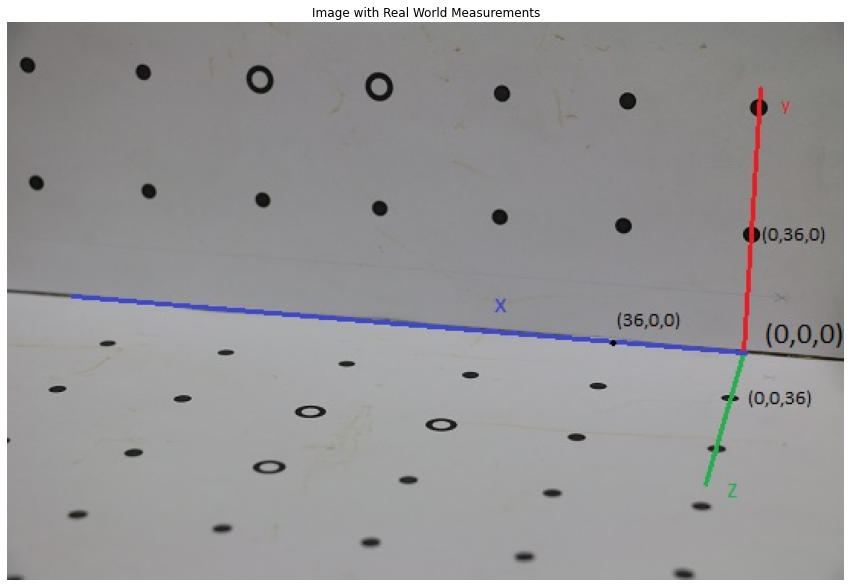

In [8]:
# Show Image having World measurements.
world_img = cv2.cvtColor(cv2.imread(img_data+"measurements.jpg"), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 12))
plt.imshow(world_img)
plt.title("Image with Real World Measurements")
plt.axis("off"); plt.show()

In [9]:
# Read the image.
blackdots_img = cv2.imread(img_data+"black-dots.JPG")[...,::-1]

In [10]:
# -------------With PLOTLY-----------------
# # plt.figure(figsize=(15, 12))
# fig = px.imshow(blackdots_img, width=1000, height=1000)#, width=500, height=500
# fig.show()

# -------------With Cv2.imshow()-----------------
while True:
    h, w, _ = blackdots_img.shape
    cv2.imshow("frame", cv2.resize(blackdots_img, (w//5, h//5), interpolation=cv2.INTER_AREA))
    if cv2.waitKey(1) == ord('q'):
        cv2.destroyAllWindows()
        break

In [11]:
# 2D Image Points.
img_points = np.asarray([[4875, 1383], [4925, 566], [4037, 1338], [4062, 517], [3225, 1279], [3242, 467], [2446, 1213], [1675, 1163], [937, 1109], [895, 326], [199, 1056], [149, 276], [4717, 2457], [4651, 2788], [4535, 3162], [4427, 3609], [3872, 2382], [3722, 2714], [3565, 3079], [3382, 3493], [3034, 2308], [2628, 2996], [2379, 3406], [2230, 2233], [1418, 3319], [1442, 2158], [1161, 2467], [845, 2817], [481, 3224]], dtype=np.int32)
world_points = np.asarray([[0, 36, 0], [0, 72, 0], [36, 36, 0], [36, 72, 0], [72, 36, 0], [72, 72, 0], [108, 36, 0], [144, 36, 0], [180, 36, 0], [180, 72, 0], [216, 36, 0], [216, 72, 0], [0, 0, 36], [0, 0, 72], [0, 0, 108], [0, 0, 144], [36, 0, 36], [36, 0, 72], [36, 0, 108], [36, 0, 144], [72, 0, 36], [72, 0, 108], [72, 0, 144], [108, 0, 36], [108, 0, 144], [144, 0, 36], [144, 0, 72], [144, 0, 108], [144, 0, 144]], dtype=np.int32)

__Estimate points through process we defined...__

In [12]:
cl = getCoords(blackdots_img, thresh=50, iters=3)

**Let's visualize the points we have taken above through MANUAL method...**

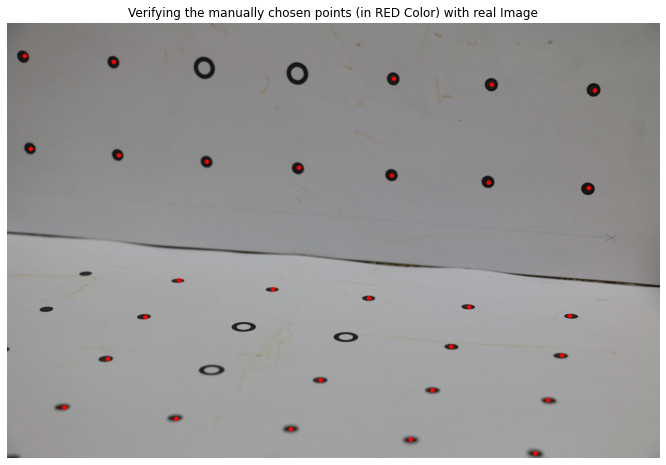

In [13]:
tmp_black = blackdots_img.copy()
for pts in img_points:
    tmp_black=cv2.drawMarker(tmp_black, (pts[0],pts[1]), color=(255,0,0), markerType=cv2.MARKER_DIAMOND, thickness=19)

plt.figure(figsize=(13, 8))
plt.imshow(tmp_black); plt.title("Verifying the manually chosen points (in RED Color) with real Image"); plt.axis("off"); plt.show()

**Let's visualize the points we have taken above through AUTO method...**

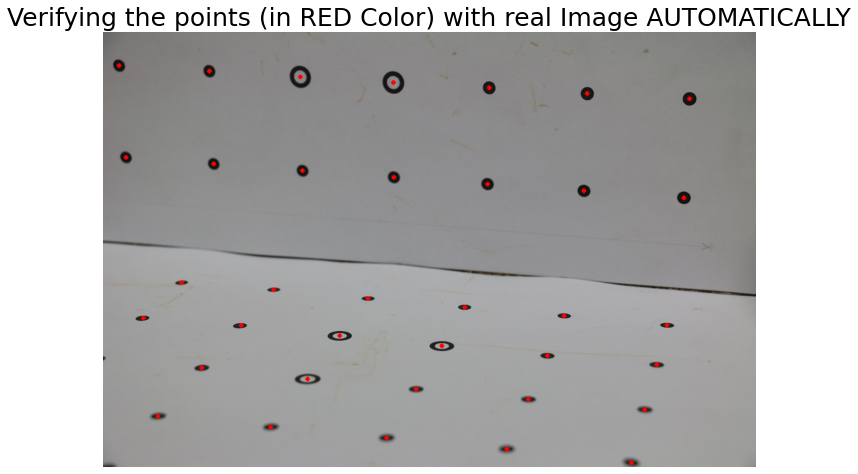

In [14]:
tmp_black = blackdots_img.copy()
for pts in cl:
    tmp_black=cv2.drawMarker(tmp_black, (pts[0],pts[1]), color=(255,0,0), markerType=cv2.MARKER_DIAMOND, thickness=19)

plt.figure(figsize=(13, 8))
plt.imshow(tmp_black); plt.title("Verifying the points (in RED Color) with real Image AUTOMATICALLY", fontsize=25); plt.axis("off"); plt.show()

**Apply `DLT` to estimate the Camera matrix...**

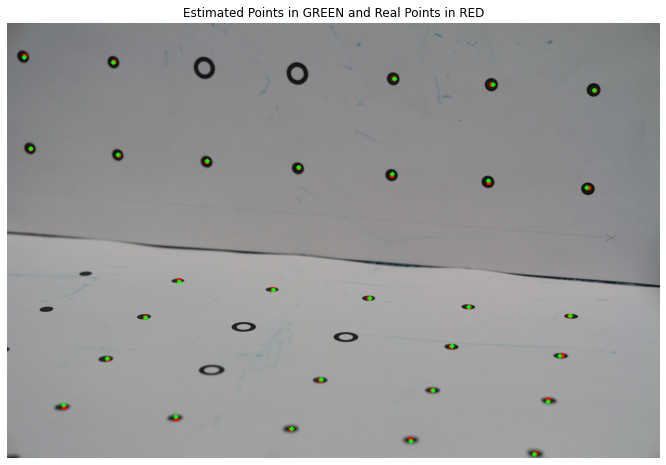

****************************************************************************************************
Reconstruction Error for the Image points = 10.939
****************************************************************************************************

Camera Matrix = [[ 2.25225232e+01 -2.28706041e-01 -5.31495723e+00]
 [ 0.00000000e+00  2.24583972e+01 -4.75175503e+00]
 [-0.00000000e+00 -0.00000000e+00 -1.77265906e-03]]
****************************************************************************************************

Rotation Matrix = [[-0.97693241  0.00690528 -0.21343708]
 [-0.09063172 -0.91840475  0.38512154]
 [-0.19336225  0.39558188  0.89784521]]
****************************************************************************************************

Translation Vector = [[-33.32326288]
 [201.19858385]
 [532.4863277 ]]


In [15]:
# Estimated Camera Matrix from 6 points (i.e., a Getting a Unique solution)
P = DLT(img_points, world_points, normalize=True)
# Decompose P into Camera matrix K, ROtation matrix R and Translation vector C
K, R, C = decomposeP(P)
# Transform World Points to 2D Image Points...
err = reconstructionError(img_points, P, world_points, show=True, img=blackdots_img)
print("*"*100)
print("Reconstruction Error for the Image points = %.3f"%err)
print("*"*100+"\n")
print(f"Camera Matrix = {K}")
print("*"*100+"\n")
print(f"Rotation Matrix = {R}")
print("*"*100+"\n")
print(f"Translation Vector = {C}")

**Apply `RANSAC based DLT` to estimate the Camera matrix...**

At Iteration: # 1 we got larger Si than previous.
----------------------------------------------------------------------------------------------------

At Iteration: # 4 we got larger Si than previous.
----------------------------------------------------------------------------------------------------

At Iteration: # 27 we got larger Si than previous.
----------------------------------------------------------------------------------------------------

No trials has produced Si larger than T, hence returning the P computed from largest Si.


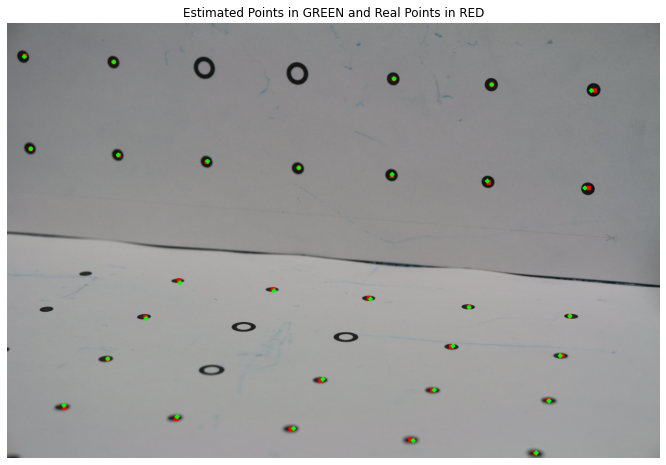

****************************************************************************************************
Reconstruction Error for the Image points (in RANSAC based DLT for all 29 image points) = 15.048
****************************************************************************************************

Camera Matrix = [[ 2.23499044e+01 -1.41123386e-01 -5.85803899e+00]
 [ 0.00000000e+00  2.25746281e+01 -4.21410810e+00]
 [-0.00000000e+00 -0.00000000e+00 -1.76730972e-03]]
****************************************************************************************************

Rotation Matrix = [[-0.98186537  0.01584265 -0.18891639]
 [-0.08355699 -0.93065486  0.35622993]
 [-0.17017233  0.36555512  0.91510154]]
****************************************************************************************************

Translation Vector = [[-32.39125449]
 [196.68000512]
 [533.73563093]]


In [16]:
# Estimated Camera Matrix
P_ransac = RANSAC(world_points, img_points, thresh=4)
# Decompose P into Camera matrix K, ROtation matrix R and Translation vector C
K_ransac, R_ransac, C_ransac = decomposeP(P_ransac)
# Transform World Points to 2D Image Points...
err = reconstructionError(img_points, P_ransac, world_points, show=True, img=blackdots_img)
print("*"*100)
print("Reconstruction Error for the Image points (in RANSAC based DLT for all %d image points) = %.3f"%(len(img_points), err))
print("*"*100+"\n")
print(f"Camera Matrix = {K_ransac}")
print("*"*100+"\n")
print(f"Rotation Matrix = {R_ransac}")
print("*"*100+"\n")
print(f"Translation Vector = {C_ransac}")

# 4) Correcting RADIAL distortions

Repeat the above experiments after correcting for **radial distortion**. Estimate the __radial distortion parameters__ from the __straight lines in the image__. What do you observe regarding the resulting parameters?

**STEPs:**

1. Calibrate camera (not with DLT or RANSAC, but with `OpenCV` function `cv2.calibrateCamera()` to get the Distortion Parameters) according to the given *World Points (Planar ONe)* and *Image Points*.
2. Using those **distortion parameters** try to **undistort** the image.
3. Repeat all the above steps on the undistorted image and compare the results. Plus, comment on the same.

Follow this [link](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d) to know more why we have followed the following steps.

In [17]:
# Zhang's method works on PLANAR world --> Considering points having z-coord = 0
world_points_2D = world_points[:12]

----------------------------------------------------------------------------------------------------
Reprojection Error:
 4.210260285912125
----------------------------------------------------------------------------------------------------

Camera Calibration Matrix:

----------------------------------------------------------------------------------------------------
[[1.67585903e+04 0.00000000e+00 2.60375868e+03]
 [0.00000000e+00 1.82233588e+04 1.56329461e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
----------------------------------------------------------------------------------------------------

Distortion Parameters:

----------------------------------------------------------------------------------------------------
[[-1.25593736e+00  1.04848711e+02 -3.48914057e-03  4.53707081e-02
  -2.09528256e+03]]
----------------------------------------------------------------------------------------------------

Rotation Vectors for the Images are:

-------------------------------

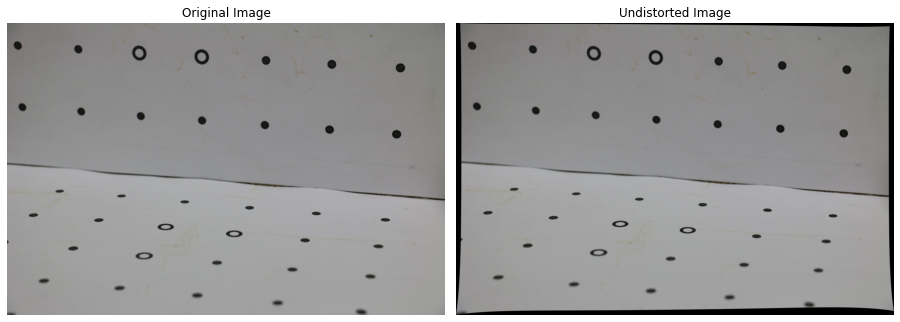

In [18]:
h, w = blackdots_img.shape[0], blackdots_img.shape[1]
ret, P_new, dist, rvecs, tvecs = cv2.calibrateCamera([world_points_2D.astype(np.float32)],[img_points[:12].astype(np.float32)], (w, h), None, None)
# cv2.calibrateCamera(np.expand_dims(world_points, axis=0).astype(np.float32), np.expand_dims(img_points, axis=0).astype(np.float32), (w, h), K, None, None, flags=(cv2.CALIB_USE_INTRINSIC_GUESS))

#refining the camera matrix
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(P_new, dist, (w, h), 1, (w, h))

#undistoring the image and cropping the roi
undist_result = cv2.undistort(blackdots_img, P_new, dist, None, newcameramtx)

# Save the image
cv2.imwrite('../images/undistorted.jpg', undist_result)

# Display the Results
print("-"*100)
print('Reprojection Error:\n', ret)
print("-"*100+"\n")
print ('Camera Calibration Matrix:\n')
print("-"*100)
print(P_new)
print("-"*100+"\n")
print('Distortion Parameters:\n')
print("-"*100)
print(dist)
print("-"*100+"\n")
print('Rotation Vectors for the Images are:\n')
print("-"*100)
print(rvecs)
print("-"*100+"\n")
print('Translation Vectors for the Images are:\n')
print("-"*100)
print(tvecs)
print("-"*100+"\n")

# Display the Images
fig, ax = plt.subplots(1, 2, figsize=(13, 13))
ax[0].imshow(blackdots_img)
ax[0].set_title('Original Image'); ax[0].set_axis_off()
ax[1].imshow(undist_result)
ax[1].set_title('Undistorted Image'); ax[1].set_axis_off()
fig.tight_layout(rect=[0, 0, 0.97, 1])
plt.show()

**Applying the above CAMERA Calibration methods - (`DLT` and `RANSAC` based DLT) on the undistorted Image...**

In [19]:
# Read the image.

# -------------With Cv2.imshow()-----------------
while True:
    cv2.imshow("frame", undist_result)
    if cv2.waitKey(1) == ord('q'):
        cv2.destroyAllWindows()
        break

In [20]:
# 2D Image Points.
img_points_undistorted = np.asarray([[4840, 1373], [4885, 579], [4045, 1315], [4071, 521], [3263, 1259], [3283, 470], [2501, 1200], [1732, 1141], [996, 1083], [957, 320], [254, 1031], [195, 275], [4703, 2405], [4618, 2727], [4507, 3078], [4403, 3508], [3889, 2329], [3745, 2655], [3589, 3013], [3413, 3417], [3068, 2264], [2670, 2935], [2429, 3339], [2273, 2192], [1472, 3254], [1491, 2127], [1205, 2420], [885, 2772], [527, 3170]], dtype=np.int32)

**Let's visualize the points we have taken above...**

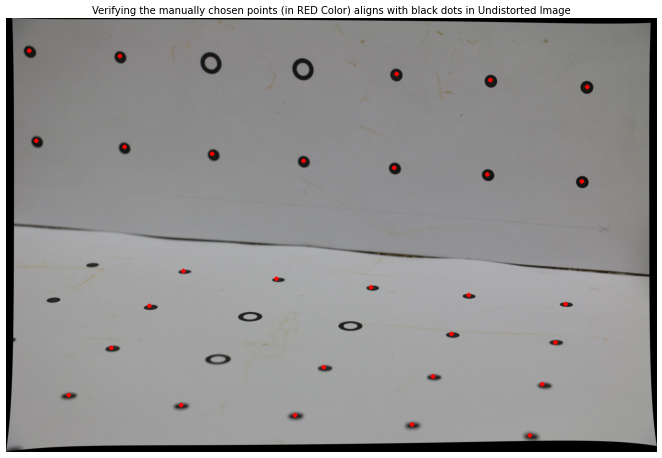

In [21]:
undist_copy = undist_result.copy()
for pts in img_points_undistorted:
    undist_copy=cv2.drawMarker(undist_copy, (pts[0],pts[1]), color=(255,0,0), markerType=cv2.MARKER_DIAMOND, thickness=19)

plt.figure(figsize=(14, 10), dpi=60)
plt.imshow(undist_copy); plt.title("Verifying the manually chosen points (in RED Color) aligns with black dots in Undistorted Image"); plt.axis("off"); plt.show()

**Apply `DLT` on UNDISTORTED image to estimate the Camera matrix...**

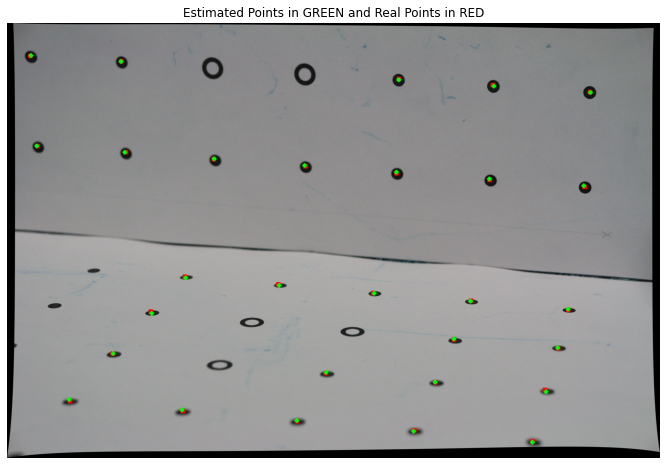

****************************************************************************************************
Reconstruction Error for the Image points = 8.879
****************************************************************************************************

Camera Matrix = [[ 2.17223926e+01 -3.48789317e-01 -7.12498930e+00]
 [ 0.00000000e+00  2.17238972e+01 -3.78193621e+00]
 [-0.00000000e+00 -0.00000000e+00 -1.71243628e-03]]
****************************************************************************************************

Rotation Matrix = [[-0.99062618  0.03500477 -0.13203951]
 [-0.08000217 -0.9321617   0.35309236]
 [-0.11072226  0.36034598  0.92622425]]
****************************************************************************************************

Translation Vector = [[-36.9164259 ]
 [205.31644575]
 [546.18620711]]


In [22]:
# Estimated Camera Matrix from 6 points (i.e., a Getting a Unique solution)
P_undist = DLT(img_points_undistorted, world_points, normalize=True)
# Decompose P into Camera matrix K, ROtation matrix R and Translation vector C
K_undist, R_undist, C_undist = decomposeP(P_undist)
# Transform World Points to 2D Image Points...
err = reconstructionError(img_points_undistorted, P_undist, world_points, show=True, img=undist_result)
print("*"*100)
print("Reconstruction Error for the Image points = %.3f"%err)
print("*"*100+"\n")
print(f"Camera Matrix = {K_undist}")
print("*"*100+"\n")
print(f"Rotation Matrix = {R_undist}")
print("*"*100+"\n")
print(f"Translation Vector = {C_undist}")

**Apply `RANSAC based DLT` on UNDISTORTED image to estimate the Camera matrix...**

At Iteration: # 1 we got larger Si than previous.
----------------------------------------------------------------------------------------------------

At Iteration: # 2 we got larger Si than previous.
----------------------------------------------------------------------------------------------------

At Iteration: # 3 we got larger Si than previous.
----------------------------------------------------------------------------------------------------

At Iteration: # 6 we got larger Si than previous.
----------------------------------------------------------------------------------------------------

At Iteration: # 11 we got larger Si than previous.
----------------------------------------------------------------------------------------------------

At Iteration: # 13 we got larger Si than previous.
----------------------------------------------------------------------------------------------------

No trials has produced Si larger than T, hence returning the P computed from largest S

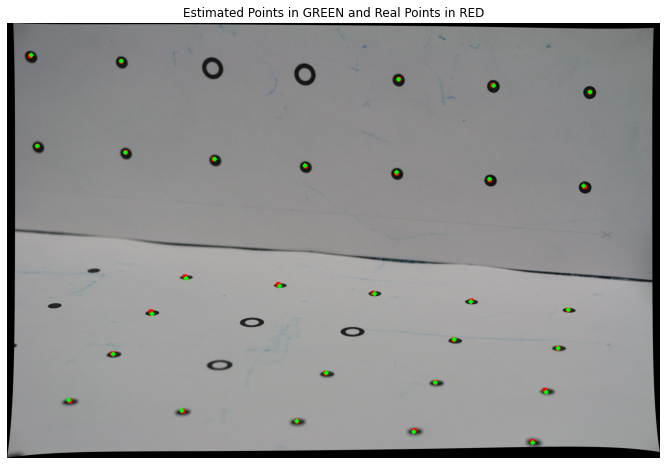

****************************************************************************************************
Reconstruction Error for the Image points (in RANSAC based DLT for all 29 image points) = 10.172
****************************************************************************************************

Camera Matrix = [[ 2.16730651e+01 -3.01346052e-01 -7.30024958e+00]
 [ 0.00000000e+00  2.18300324e+01 -3.82842920e+00]
 [-0.00000000e+00 -0.00000000e+00 -1.72754227e-03]]
****************************************************************************************************

Rotation Matrix = [[-0.99109214  0.03606114 -0.12820279]
 [-0.0792581  -0.93331881  0.3501916 ]
 [-0.10702577  0.35723326  0.92786307]]
****************************************************************************************************

Translation Vector = [[-37.04338345]
 [201.66942149]
 [541.94356025]]


In [23]:
# Estimated Camera Matrix
P_ransac_undist = RANSAC(world_points, img_points_undistorted, thresh=4)
# Decompose P into Camera matrix K, ROtation matrix R and Translation vector C
K_ransac_undist, R_ransac_undist, C_ransac_undist = decomposeP(P_ransac_undist)
# Transform World Points to 2D Image Points...
err_R = reconstructionError(img_points_undistorted, P_ransac_undist, world_points, show=True, img=undist_result)
print("*"*100)
print("Reconstruction Error for the Image points (in RANSAC based DLT for all %d image points) = %.3f"%(len(img_points), err_R))
print("*"*100+"\n")
print(f"Camera Matrix = {K_ransac_undist}")
print("*"*100+"\n")
print(f"Rotation Matrix = {R_ransac_undist}")
print("*"*100+"\n")
print(f"Translation Vector = {C_ransac_undist}")

# 5) Compute Image of a WIREFRAME of the Object

Use the real-world measurements that are provided along with the estimated camera parameters to compute the image of a wireframe of the object. Note that you will be computing the location of image points as $x_i = P X_i$, and not use the image points. Overlay (draw) the wireframe over the actual image of the object using straight
lines between the computed points $x_i$. What do you observe about the overlay?

**Steps:**
1. Using camera matrix estimate the Image POINTS using world points.
2. Join those estimated image points with LINES to create wireframe.

In [24]:
# compute image points from P matrix
def computeImgPoints(world_points, P):
    """
    world_points: 2D numpy array with points stacked vertically
    P: camera matrix
    """
    # P_(3 x 4)*WP_(4 x n)
    est_pts = np.dot(P, np.concatenate((world_points.T, np.ones((1, world_points.shape[0])) )) )
    # u = x/z and v = y/z
    return (est_pts/est_pts[2,:])[:2, :].T

# function that draw lines according to the estimated points...
def drawLines(x1, x2, image, thickness=20):
    """
    x1: first co-ordinate
    x2: Second co-ordinate
    image: on which line is to be drawn
    thickness: Line thickness
    """
    x1, x2 = tuple(x1.astype(np.int32)), tuple(x2.astype(np.int32))
    return cv2.line(image, x1, x2, (0,255,0), thickness)

# Draw on the Image.
def drawMeshGrid(pts, image):
    """
    pts: type=ARRAY
        Through which meshes are to be placed
        (provide in row-wise fashion - 2 rows i.e., two consecutive rows as in real world.)
    image: On which mesh is to be drawn.
    """
    tmp_copy=image.copy()
    for row in pts:
        for idx in range(len(row)-1):
            # draw in row-wise
            tmp_copy = drawLines(row[idx], row[idx+1], tmp_copy)
    for k in range(pts.shape[1]):
        # Draw in column-wise
        tmp_copy = drawLines(pts[:, k][0], pts[:, k][1], tmp_copy)
    return tmp_copy

In [25]:
# Add some more points on the FOLD to get a line on the paper fold.
wp_set = {1:np.asarray([[36*k, 72, 0] for k in range(7)], dtype=np.int32),
          2:np.asarray([[36*k, 36, 0] for k in range(7)], dtype=np.int32),
          3:np.asarray([[36*k, 0, 0] for k in range(7)], dtype=np.int32),
          4:np.asarray([[36*k, 0, 36] for k in range(6)], dtype=np.int32),
          5:np.asarray([[36*k, 0, 72] for k in range(6)], dtype=np.int32),
          6:np.asarray([[36*k, 0, 36*3] for k in range(5)], dtype=np.int32),
          7:np.asarray([[36*k, 0, 36*4] for k in range(5)], dtype=np.int32)}

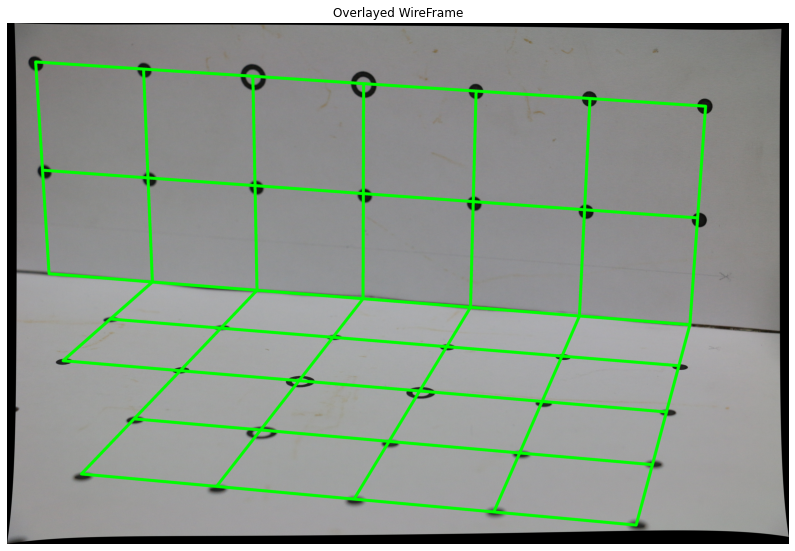

In [26]:
# Overlay Wireframe
two_row_arr = np.concatenate((np.array([computeImgPoints(wp_set[1], P_undist)]), np.array([computeImgPoints(wp_set[2], P_undist)])), axis=0)
tmp_img = drawMeshGrid(two_row_arr, undist_result)

two_row_arr = np.concatenate((np.array([computeImgPoints(wp_set[2], P_undist)]), np.array([computeImgPoints(wp_set[3], P_undist)])), axis=0)
tmp_img = drawMeshGrid(two_row_arr, tmp_img)

two_row_arr = np.concatenate((np.array([computeImgPoints(wp_set[3][:-1], P_undist)]), np.array([computeImgPoints(wp_set[4], P_undist)])), axis=0)
tmp_img = drawMeshGrid(two_row_arr, tmp_img)

two_row_arr = np.concatenate((np.array([computeImgPoints(wp_set[4], P_undist)]), np.array([computeImgPoints(wp_set[5], P_undist)])), axis=0)
tmp_img = drawMeshGrid(two_row_arr, tmp_img)

two_row_arr = np.concatenate((np.array([computeImgPoints(wp_set[5][:-1], P_undist)]), np.array([computeImgPoints(wp_set[6], P_undist)])), axis=0)
tmp_img = drawMeshGrid(two_row_arr, tmp_img)

two_row_arr = np.concatenate((np.array([computeImgPoints(wp_set[6], P_undist)]), np.array([computeImgPoints(wp_set[7], P_undist)])), axis=0)
tmp_img = drawMeshGrid(two_row_arr, tmp_img)

# Show the Wireframed blackdots_img...
plt.figure(figsize=(14, 10))
plt.imshow(tmp_img); plt.title("Overlayed WireFrame"); plt.axis("off"); plt.show()

# 6) Calibration using Zhang's method

Repeat the calibration of the camera using Zhang’s method using either the available `OpenCV` or `Matlab` implementation. How does your results compare with `DLT` based method?

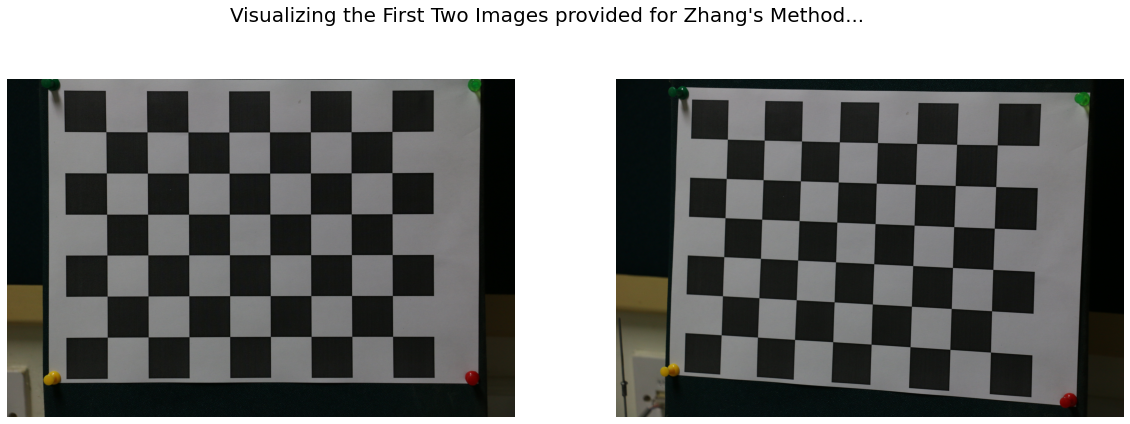

In [27]:
# read Images
I1 = cv2.imread(img_data+'checkerboard-01.JPG')
I2 = cv2.imread(img_data+'checkerboard-02.JPG')

# Scale images to LOWER shape (decreasing pixel count).
# scale_percent = 30 # percent of original size
# height, width = np.int32(I1.shape * scale_percent / 100)
# dim = (width, height)
# I1 = cv2.resize(I1, dim, interpolation = cv2.INTER_AREA)
# I2 = cv2.resize(I2, dim, interpolation = cv2.INTER_AREA)

# Show the scaled Images...
plt.figure(figsize=(20, 7))
plt.subplot(121)
plt.imshow(I1[...,::-1])# Convert to RGB
plt.axis('off')
plt.subplot(122)
plt.imshow(I2[...,::-1])# Convert to RGB
plt.suptitle("Visualizing the First Two Images provided for Zhang's Method...", fontsize=20)
plt.axis('off')
plt.show()

In [28]:
# Find corners of the (First Image) I1 using below OpenCV function...
ret, corners = cv2.findChessboardCorners(I1, (8, 6), flags=cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE)
corners = corners.reshape(-1,2)

# Define World-Points for ChessBoards
x, y=np.meshgrid(range(8), range(6))
cb_wp=np.hstack((x.reshape(48, 1), y.reshape(48, 1), np.zeros((48, 1)))).astype(np.float32)

In [29]:
# Print The Corners and it's shape..
print("First 5 Corners: ", corners[:5, :])
print("Shape of Corners: ", corners.shape)

First 5 Corners:  [[1070.5607   582.6061 ]
 [1513.       584.5    ]
 [1953.3451   586.5297 ]
 [2396.1528   587.337  ]
 [2831.205    585.28864]]
Shape of Corners:  (48, 2)


__Compute the Camera calibration matrix $=\mathbf{P}$ for each ChessBoard Orientation, where $\mathbf{K}$ is fixed and $\mathbf{R[I|-C]}$ is changing due to different views of ChessBoard.__

In [30]:
_3d_points=[]
_2d_points=[]

for i in range(1,16):
    if i//10 == 0:
        im=cv2.imread('../data/checkerboard-0' + str(i) + '.JPG')
    else:
        im=cv2.imread('../data/checkerboard-' + str(i) + '.JPG')
    
    # Find Chess Board Corners
    ret, corners = cv2.findChessboardCorners(im, (8,6), flags=cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    if ret: #add points only if checkerboard was correctly detected:
        # We're here collecting as many points possible
        _2d_points.append(corners) #append current 2D points
        _3d_points.append(cb_wp) #3D points are always the same for every images
        
ret, K_mtx, distCoeff, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]), None, None)

print("-"*100)
print('Reprojection Error:', ret)
print("="*100+"\n")
print ('Camera Calibration Matrix:')
print("-"*100)
print(K_mtx)
print("="*100+"\n")
print('Distortion Parameters:')
print("-"*100)
print(distCoeff)
print("="*100+"\n")
print('Rotation Vectors for the images are:')
print("-"*100)
print(rvecs)
print("="*100+"\n")
print('Translation Vectors for the images are:')
print("-"*100)
print(tvecs)
print("="*100+"\n")

----------------------------------------------------------------------------------------------------
Reprojection Error: 2.481084983863818

Camera Calibration Matrix:
----------------------------------------------------------------------------------------------------
[[1.36634773e+04 0.00000000e+00 3.33653656e+03]
 [0.00000000e+00 1.36813826e+04 1.49660118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Parameters:
----------------------------------------------------------------------------------------------------
[[ 9.52132296e-02  1.01092580e+01 -1.52797799e-02  2.87213434e-02
  -1.60589622e+02]]

Rotation Vectors for the images are:
----------------------------------------------------------------------------------------------------
[array([[-0.01318085],
       [-0.05189257],
       [-0.00310183]]), array([[-0.00723369],
       [ 0.22652165],
       [ 0.03532859]]), array([[-0.00906861],
       [-0.41619662],
       [-0.03572076]]), array([[ 0.01633962],
       [-0

# 7) Overlay Wireframe using `Zhang's` method.

Repeat the overlay of wireframe using the internal parameters estimated from Zhang’s method. Describe your observations.

In [44]:
# Function to convert the Rotation Matrix into the Euler Angles
def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,0,0],[0,np.cos(theta[0]),-np.sin(theta[0])],[0,np.sin(theta[0]), np.cos(theta[0])]])
    R_y = np.array([[np.cos(theta[1]),0,np.sin(theta[1])],[0,1,0],[-np.sin(theta[1]),0,np.cos(theta[1])]])             
    R_z = np.array([[np.cos(theta[2]),-np.sin(theta[2]),0],[np.sin(theta[2]),np.cos(theta[2]),0],[0,0,1]])
    R = np.dot(R_z,np.dot(R_y,R_x))
    return R

# Deploys Wireframe over Chessboards
def deployWireFrame(chess_coords, ax, image):
    """
    Takes in the co-ordinates of Image estimated from camera matrix and World points and using those estimated co-ordinates wireframe is drawn over the Image.
    """
    # chess_tmp = sorted(chess_tmp, key=lambda x:x[0])
    # reconstruct a matrix that stores co-ordinates
    req_mat = np.expand_dims(chess_coords[:8], axis=0)
    for k in range(8, 48, 8):
        coords = chess_coords[k:k+8]
        req_mat = np.concatenate((req_mat, np.expand_dims(coords, axis=0)), axis=0)
        ax.plot(coords[:,0], coords[:,1], 'go-')
    # put line according to these points row-wise (done above) and then column-wise
    for l in range(8): # for all 8 columns
        ax.plot(req_mat[:, l, 0], req_mat[:, l, 1], 'go-')

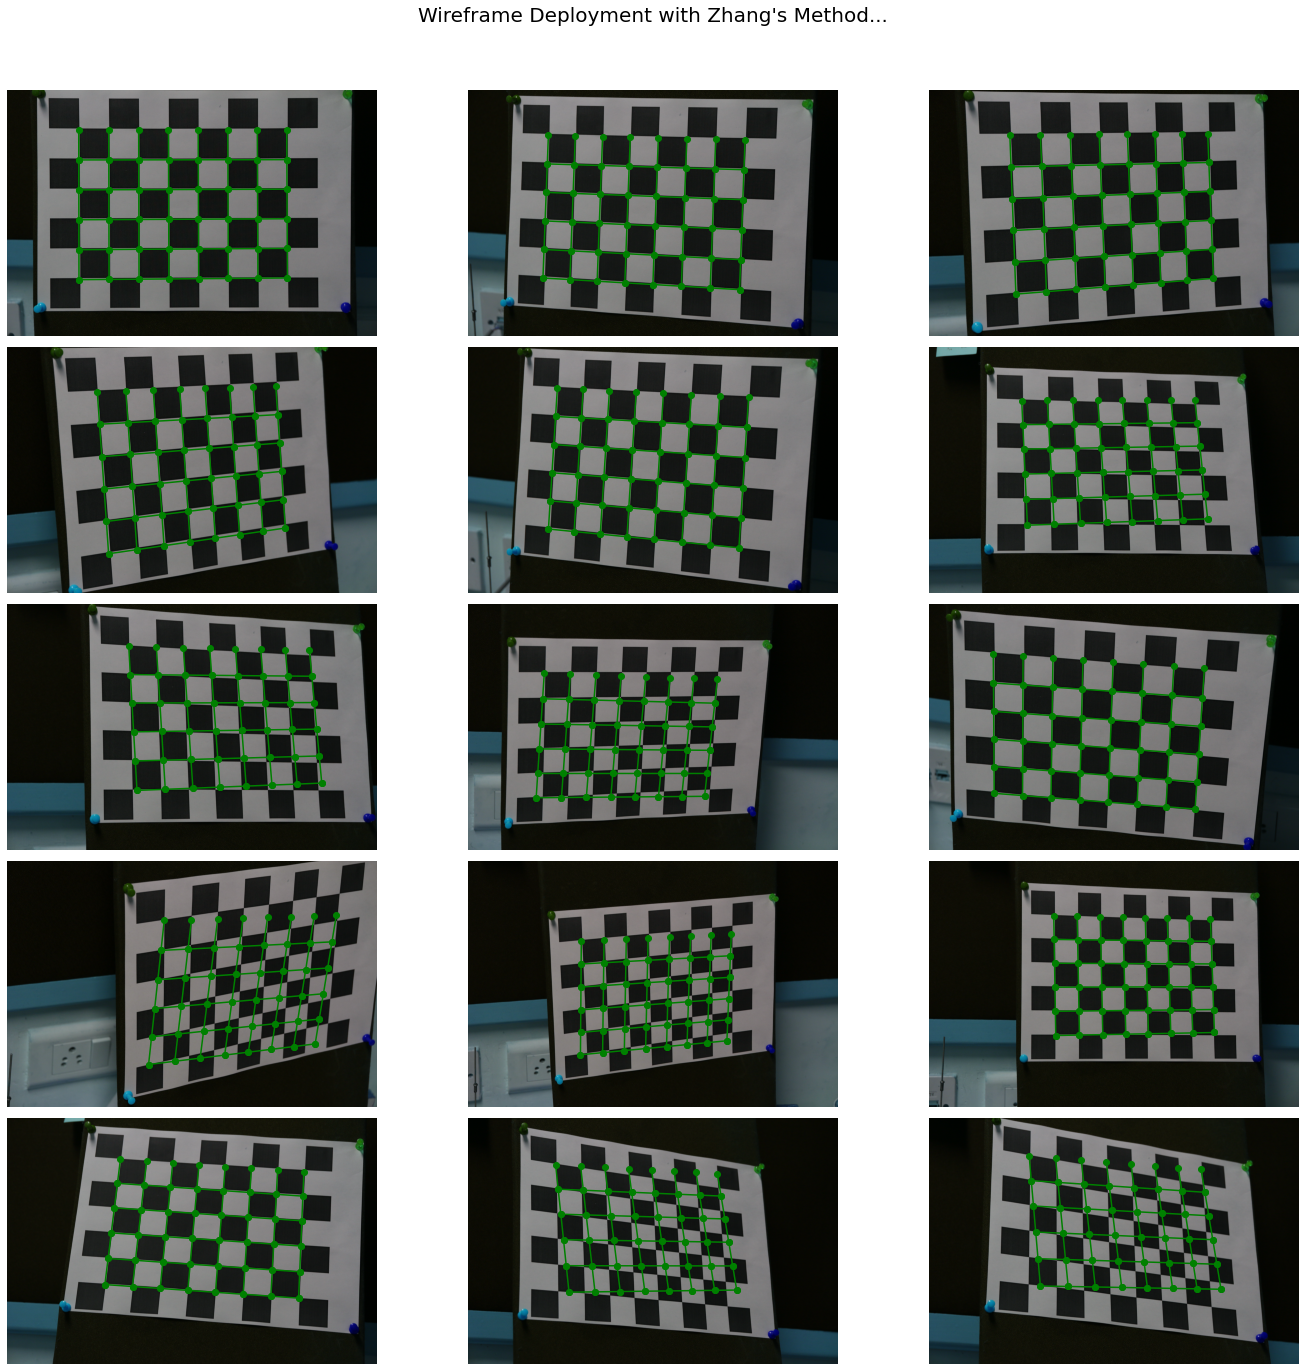

In [32]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize = (20, 20))
fig.suptitle("Wireframe Deployment with Zhang's Method...", fontsize=20)

for k in range(15):
    # Compute the Rotation matrix from Rotation vector using Claibration Function of OpenCV.
    R = np.asarray(eulerAnglesToRotationMatrix(rvecs[k].squeeze()))
    # Extrinsic params = R[I|-C]
    extrinsic_params = np.append(R, tvecs[k], axis=1)
    
    # camera matrix = P = KR[I|-C]
    P_z = np.dot(K_mtx, extrinsic_params)
    P_z = P_z/P_z[-1,-1]
    # print("P_z = ", P_z)
    
    
    # print(f"Calbration Matrix for ChessBoard {k+1}: \n")
    # print("-"*100)
    # print(P_z)
    # print("="*100+"\n")
    
    # get homogenous world coordinates for the image
    homo_wp = np.append(_3d_points[k], np.ones((_3d_points[k].shape[0],1)), axis=1)

    # get projected image points
    imgpoints_proj = np.dot(P_z, homo_wp.T)
    # u = x/z, v = y/z
    imgpoints_proj = (imgpoints_proj / imgpoints_proj[-1, :])[:2, :].T
    
    # ======================================================
    ### Wireframe
    if (k+1)//10 == 0:
        im=cv2.imread('../data/checkerboard-0' + str(k+1) + '.JPG')
    else:
        im=cv2.imread('../data/checkerboard-' + str(k+1) + '.JPG')
    ax[k//3, k%3].imshow(im)
    deployWireFrame(imgpoints_proj, ax[k//3, k%3], im)
    ax[k//3, k%3].set_axis_off()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Observations :

- Looking at above wireframe overlays on the chessboard images, we observe that the images to which the camera axis plane is *almost* perpendicular to the object plane, the estimated image points (or the projected world points) coincide with the true image points. 
- However, there still exists a small *mismatch* (or say the reconstruction error) in case of few chessboard images. Further, a close observation would reveal that the rotation of the camera angle here is relatively **larger**.

# 8) Compute Image of World Origin

What is the image of the world origin, given the calibration matrix? Does this result bear out in your observations?

__Answer:__

1. The world origin in 3D euclidean space is $\begin{bmatrix}0\\0\\0\end{bmatrix}$ which when transformed to *Homogenous* co-ordinates becomes $\begin{bmatrix}0\\0\\0\\1\end{bmatrix}_{\ 4\times 1}$. Calibration matrix, $\mathbf{P}$, of shape $3\times 4$ when act on this point gives $\mathbf{p_4}$ the fourth column of matrix $\mathbf{P}$.
$\begin{align*}
\mathbf{P}_{3\times 4}\begin{bmatrix}0\\0\\0\\1\end{bmatrix}_{\ 4\times 1} = \begin{bmatrix}\mathbf{p_1}\ \mathbf{p_2}\ \mathbf{p_3}\ \mathbf{p_4}\end{bmatrix}_{3\times 4}\begin{bmatrix}0\\0\\0\\1\end{bmatrix}_{\ 4\times 1} = \mathbf{p_4}
\end{align*}$
2. In our case the point $\begin{bmatrix}4778\\2112\end{bmatrix}$ in Image is where the fold in paper starts (from right).

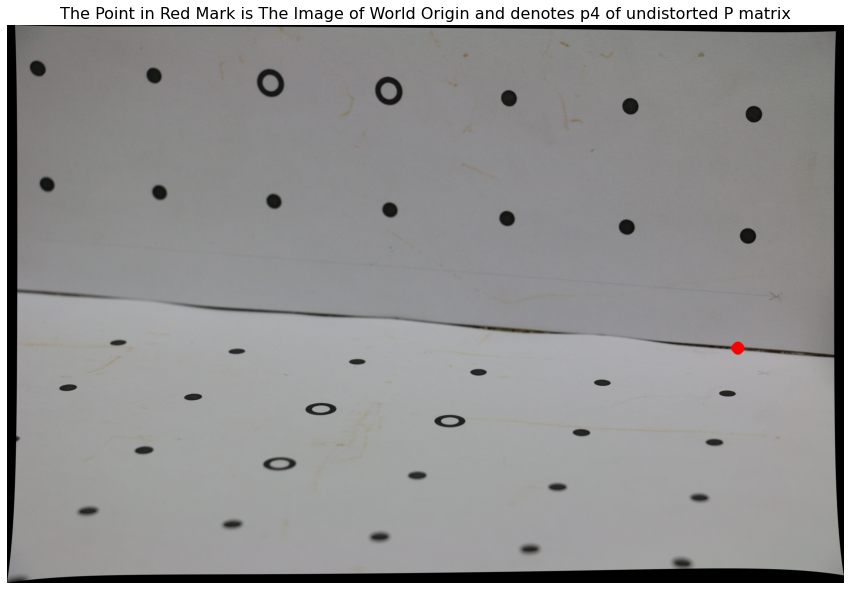

In [33]:
# Show that sepcific POINT.
tmp_img_1 = undist_result.copy()
plt.figure(figsize=(15, 12))
plt.imshow(cv2.drawMarker(tmp_img_1, (int(P_undist[0,3]), int(P_undist[1,3])), color=(255,0,0), markerType=cv2.MARKER_DIAMOND, thickness=65))
plt.title("The Point in Red Mark is The Image of World Origin and denotes p4 of undistorted P matrix", fontsize=16); plt.axis('off'); plt.show()

# 9) Select a Camera.

Select a camera that you would like to use for the assignments. Note that you might be using this camera for future assignments also. This could be your laptop camera, mobile phone camera or any other digital camera that you have access to.

**Selected my own Mobile camera for the puprpose...**

# 10) Above 3 Calibration method on our own camera and our own calibration object.

Repeat the **3 calibration methods** using your own camera and your own calibration object for which you measure and determine the world co-ordinates. Use a **printed checkerboard pattern** for **Zhang’s method**. Describe and comment on the results of each method.

In [34]:
# Read the image.
gift = cv2.imread(img_our+"check_box.jpeg")[...,::-1]# BGR to RGB

# -------------With Cv2.imshow()-----------------
while True:
    cv2.imshow("frame", gift)
    if cv2.waitKey(1) == ord('q'):
        cv2.destroyAllWindows()
        break

In [35]:
# box World patterns
wp_box = np.asarray([[0, 0, 0], [1, 0, 0], [0, 0, 1], [0, 1, 0], [1, 1, 0], [1, 2, 0], [3, 1, 0], [0, 1, 3], [3, 2, 0]], dtype=np.int32)
ip_box = np.asarray([[220, 603], [404, 582], [148, 570], [227, 791], [409, 770], [411, 945], [726, 717], [45, 671], [721, 878]], dtype=np.int32)

**Let's visualize the points we have taken above...**

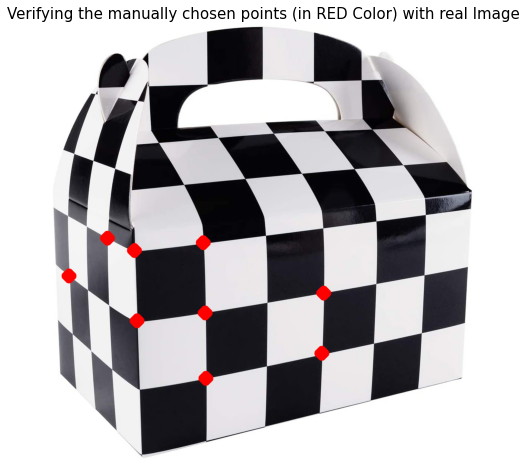

In [36]:
tmp_gift = gift.copy()

# Show the Image Points recorded manually overlayed on Image. 
for pts in ip_box:
    tmp_gift=cv2.drawMarker(tmp_gift, (pts[0],pts[1]), color=(255,0,0), markerType=cv2.MARKER_DIAMOND, thickness=20)

plt.figure(figsize=(13, 8))
plt.imshow(tmp_gift); plt.title("Verifying the manually chosen points (in RED Color) with real Image", fontsize=15); plt.axis("off"); plt.show()

#### **Apply `DLT` to estimate the Camera matrix...**

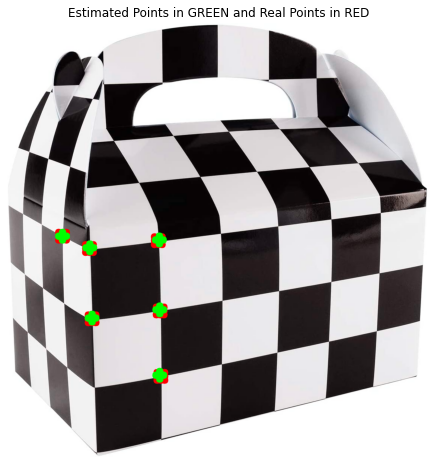

****************************************************************************************************
Reconstruction Error for the Image points = 2.540
****************************************************************************************************

Camera Matrix = [[-1.89867362e+02  1.00143805e+01  1.17970397e+16]
 [-0.00000000e+00 -1.97144622e+02  4.54345449e+16]
 [ 0.00000000e+00  0.00000000e+00  7.97097279e+13]]
****************************************************************************************************

Rotation Matrix = [[-9.94797850e-01 -1.01868725e-01  2.09961035e-16]
 [ 1.01868725e-01 -9.94797850e-01  4.09543642e-16]
 [ 1.67149098e-16  4.28801598e-16  1.00000000e+00]]
****************************************************************************************************

Translation Vector = [[-3.76059262e-01]
 [-1.97132788e-01]
 [-1.23981314e-14]]


In [37]:
# Estimated Camera Matrix from 6 points (i.e., a Getting a Unique solution)
P_box = DLT(ip_box[:6], wp_box[:6], normalize=True)
# Decompose P into Camera matrix K, ROtation matrix R and Translation vector C
K_box, R_box, C_box = decomposeP(P_box)
# Transform World Points to 2D Image Points...
err_box = reconstructionError(ip_box[:6], P_box, wp_box[:6], show=True, img=gift)
print("*"*100)
print("Reconstruction Error for the Image points = %.3f"%err_box)
print("*"*100+"\n")
print(f"Camera Matrix = {K_box}")
print("*"*100+"\n")
print(f"Rotation Matrix = {R_box}")
print("*"*100+"\n")
print(f"Translation Vector = {C_box}")

#### **Apply `RANSAC based DLT` to estimate the Camera matrix...**

At Iteration: # 1 we got larger Si than previous.
----------------------------------------------------------------------------------------------------

Wohoo! Jackpot.
We got |Si|>T. Discarding previous Si's if any.


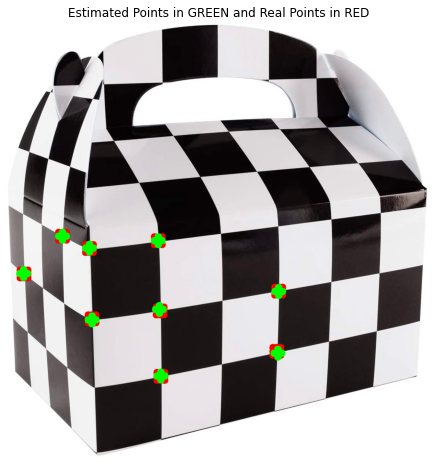

****************************************************************************************************
Reconstruction Error for the Image points (in RANSAC based DLT for all 9 image points) = 2.722
****************************************************************************************************

Camera Matrix = [[-2.07752540e+02 -1.50529831e+00  3.30047710e+01]
 [-0.00000000e+00 -1.99384569e+02  5.77892019e+01]
 [ 0.00000000e+00  0.00000000e+00  1.10326631e-01]]
****************************************************************************************************

Rotation Matrix = [[-0.90823691 -0.02080454  0.41793885]
 [ 0.08536303 -0.98697267  0.13637483]
 [ 0.40965701  0.15953718  0.89818095]]
****************************************************************************************************

Translation Vector = [[-3.33191337]
 [-1.82538421]
 [-8.24759909]]


In [38]:
# Estimated Camera Matrix
P_ransac_box = RANSAC(wp_box, ip_box, thresh=5, num_pts=6)
# world_pts, img_pts, thresh=5, num_pts=20, normalize=True
# Decompose P into Camera matrix K, ROtation matrix R and Translation vector C
K_ransac_box, R_ransac_box, C_ransac_box = decomposeP(P_ransac_box)
# Transform World Points to 2D Image Points...
err_box = reconstructionError(ip_box, P_ransac_box, wp_box, show=True, img=gift)
print("*"*100)
print("Reconstruction Error for the Image points (in RANSAC based DLT for all %d image points) = %.3f"%(len(ip_box), err_box))
print("*"*100+"\n")
print(f"Camera Matrix = {K_ransac_box}")
print("*"*100+"\n")
print(f"Rotation Matrix = {R_ransac_box}")
print("*"*100+"\n")
print(f"Translation Vector = {C_ransac_box}")

#### Zhang's Method

Since Zhang's calibration method is using 2D world information, changing focus will not affect results.

We can observe that the focal length is inversely proportional to the focussed distance. Since phone cameras are do not acknowledge much changes in focal distance compared to actual ground distance, the parameters $fx$ and $fy$ are not much affected. Rest all parameters should ideally be same, but owing to lighting and human motion variation, even they will change slightly.

__Requirement:__
1. Images should be of CHESSBOARDS.
2. Should be Black and White
3. Plus, the chess board border should be purely white as if it were printed on paper.
3. Unless, `cv2.findChessboardCorners()` will return `None`.

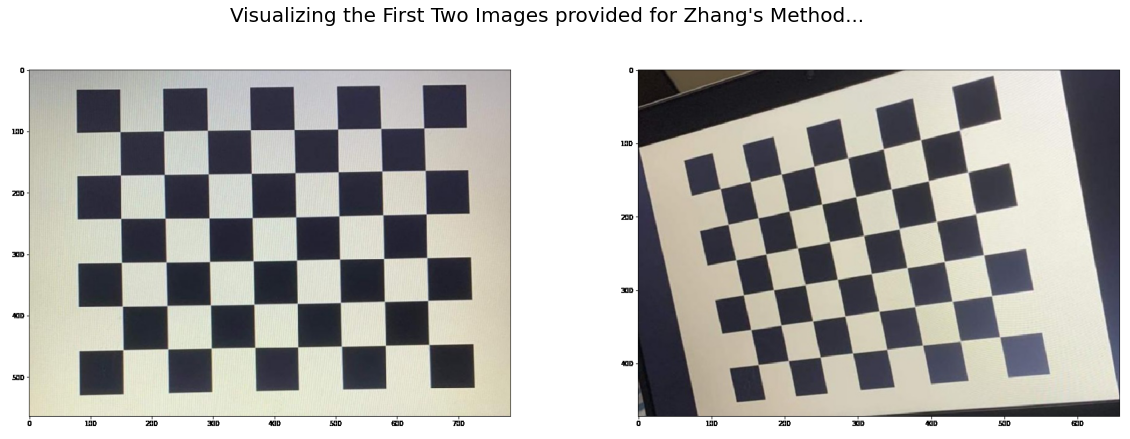

In [34]:
# read Images
I1_checker = cv2.imread(img_our+'zhang11.png')
I2_checker = cv2.imread(img_our+'zhang12.png')

# REsize Image
# I1_checker = cv2.resize(I1_checker, (I1_checker.shape[1]//4, I1_checker.shape[0]//4), interpolation = cv2.INTER_AREA)
# I2_checker = cv2.resize(I2_checker, (I2_checker.shape[1]//4, I2_checker.shape[0]//4), interpolation = cv2.INTER_AREA)

# Show the scaled Images...
plt.figure(figsize=(20, 7))
plt.subplot(121)
plt.imshow(I1_checker[...,::-1])# Convert to RGB
plt.axis('off')
plt.subplot(122)
plt.imshow(I2_checker[...,::-1])# Convert to RGB
plt.suptitle("Visualizing the First Two Images provided for Zhang's Method...", fontsize=20)
plt.axis('off')
plt.show()

In [35]:
# Find corners of the (First Image) I1 using below OpenCV function...
ret_checker, corners_checker = cv2.findChessboardCorners(I1_checker,(8, 6))
# ,flags=cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE+cv2.CALIB_CB_FAST_CHECK
corners_checker = corners_checker.reshape(-1,2)

# Define World-Points for ChessBoards
x_checker, y_checker=np.meshgrid(range(8), range(6))
cb_wp_checker=np.hstack((x_checker.reshape(48, 1), y_checker.reshape(48, 1), np.zeros((48, 1)))).astype(np.float32)

In [36]:
# Print The Corners and it's shape..
print("First 5 Corners: ", corners_checker[:5, :])
print("Shape of Corners: ", corners_checker.shape)

First 5 Corners:  [[170.4865   103.46854 ]
 [235.81978  102.48579 ]
 [302.0149   101.4967  ]
 [366.80655  100.713425]
 [432.56113  100.29575 ]]
Shape of Corners:  (48, 2)


__Compute the Camera calibration matrix $=\mathbf{P}$ for each ChessBoard Orientation, where $\mathbf{K}$ is fixed and $\mathbf{R[I|-C]}$ is changing due to different views of ChessBoard.__

In [43]:
_3d_points_checker=[]
_2d_points_checker=[]

for i in range(1,3):
    im=cv2.imread('../images/zhang1' + str(i) + '.png')
    
    # Find Chess Board Corners
    ret_checker, corners_checker = cv2.findChessboardCorners(im, (8, 6), flags=cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    if ret_checker: #add points only if checkerboard was correctly detected:
        # We're here collecting as many points possible
        _2d_points_checker.append(corners_checker) #append current 2D points
        _3d_points_checker.append(cb_wp_checker) #3D points are always the same for every images
        
ret_checker, K_mtx_checker, distCoeff_checker, rvecs_checker, tvecs_checker = cv2.calibrateCamera(_3d_points_checker, _2d_points_checker, (im.shape[1],im.shape[0]), None, None)

print("-"*100)
print('Reprojection Error:', ret_checker)
print("="*100+"\n")
print ('Camera Calibration Matrix:')
print("-"*100)
print(K_mtx_checker)
print("="*100+"\n")
print('Distortion Parameters:')
print("-"*100)
print(distCoeff_checker)
print("="*100+"\n")
print('Rotation Vectors for the images are:')
print("-"*100)
print(rvecs_checker)
print("="*100+"\n")
print('Translation Vectors for the images are:')
print("-"*100)
print(tvecs_checker)
print("="*100+"\n")

----------------------------------------------------------------------------------------------------
Reprojection Error: 0.5879269084812074

Camera Calibration Matrix:
----------------------------------------------------------------------------------------------------
[[1.13197835e+03 0.00000000e+00 3.77648737e+02]
 [0.00000000e+00 1.12965286e+03 3.04281737e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Parameters:
----------------------------------------------------------------------------------------------------
[[ 4.83103253e-01 -7.51636669e+00 -6.36703588e-03  2.77553504e-03
   2.92154954e+01]]

Rotation Vectors for the images are:
----------------------------------------------------------------------------------------------------
[array([[-0.0239517 ],
       [-0.02406452],
       [-0.01702083]]), array([[ 0.10802851],
       [ 0.44030039],
       [-0.18332793]])]

Translation Vectors for the images are:
----------------------------------------------------------

**Overlay Wireframe using `Zhang's` method.**

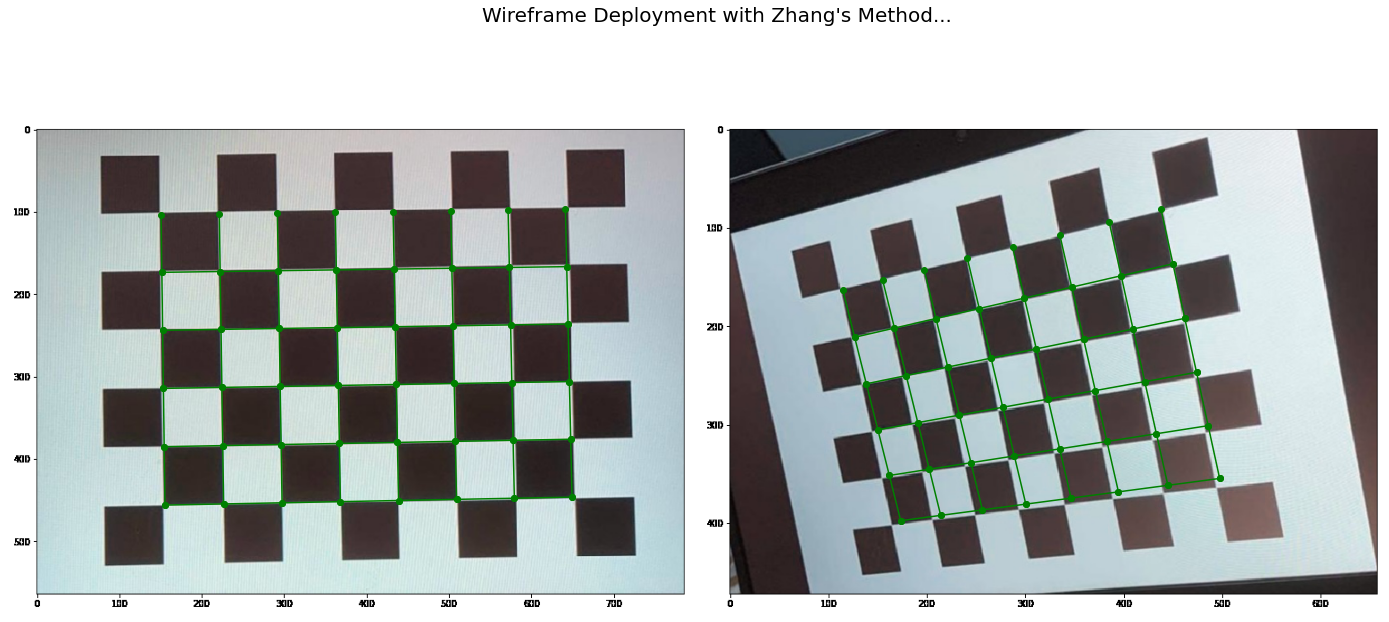

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 10))
fig.suptitle("Wireframe Deployment with Zhang's Method...", fontsize=20)

for k in range(2):
    # Compute the Rotation matrix from Rotation vector using Claibration Function of OpenCV.
    R_checker = np.asarray(eulerAnglesToRotationMatrix(rvecs_checker[k].squeeze()))
    # Extrinsic params = R[I|-C]
    extrinsic_params_checker = np.append(R_checker, tvecs_checker[k], axis=1)
    
    # camera matrix = P = KR[I|-C]
    P_z_checker = np.dot(K_mtx_checker, extrinsic_params_checker)
    P_z_checker = P_z_checker/P_z_checker[-1,-1]
    # print("P_z = ", P_z)
    
    
    # print(f"Calbration Matrix for ChessBoard {k+1}: \n")
    # print("-"*100)
    # print(P_z)
    # print("="*100+"\n")
    
    # get homogenous world coordinates for the image
    homo_wp_checker = np.append(_3d_points_checker[k], np.ones((_3d_points_checker[k].shape[0],1)), axis=1)

    # get projected image points
    imgpoints_proj_checker = np.dot(P_z_checker, homo_wp_checker.T)
    # u = x/z, v = y/z
    imgpoints_proj_checker = (imgpoints_proj_checker / imgpoints_proj_checker[-1, :])[:2, :].T
    
    # ======================================================
    ### Wireframe
    im=cv2.imread('../images/zhang1' + str(k+1) + '.png')
    ax[k].imshow(im)
    deployWireFrame(imgpoints_proj_checker, ax[k], im)
    ax[k].set_axis_off()

fig.tight_layout(rect=[0, 0, 0.97, 1])
plt.show()

#### Inference

We saw that with **RANSAC** the reconstruction error shoots UP a bit in comparison to the **DLT**. And a plausible explanation for such behaviour is due to the algorithmic demand of **RANSAC**, where a part of the total points is consider to construct the $\mathbf{P}$ matrix (less information about outer world). And with that we try to predict the projected points for world points (i.e., the estimated image points.)